In [23]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from numba import njit
from torch.utils.data import Dataset, DataLoader

os.environ['KERAS_BACKEND'] = 'torch'
import bayesflow as bf

from bayesflow import diagnostics
from diffusion_model.helper_networks import ShallowSet, SetTransformer

from diffusion_model import ScoreModel, SDE, train_score_model, count_parameters

In [2]:
torch_device = torch.device("cuda")

In [3]:
def draw_prior():
    p_samples = np.random.uniform(low=(-3.0, 0.1, 0.1, 0.1),
                                  high=(3.0, 3.0, 1.0, 0.9))
    return dict(drift=p_samples[0], boundary=p_samples[1], ndt=p_samples[2], beta=p_samples[3])

@njit
def diffusion_trial(drift, boundary, ndt, beta, dc=1.0, dt=1e-3):
    """Simulates a trial from the diffusion model."""

    n_steps = 0.
    evidence = boundary * beta

    # Simulate a single DM path
    while (evidence > 0 and evidence < boundary):

        # DDM equation
        evidence += drift*dt + np.sqrt(dt) * dc * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt + ndt
    if evidence >= boundary:
        return rt, 1.
    return rt, 0.


def simulate_trials(drift, boundary, ndt, beta, n_trials=100):
    """Simulates a diffusion process for trials ."""
    choicert = np.empty((n_trials, 2))
    for i in range(n_trials):
        choicert[i] = diffusion_trial(drift, boundary, ndt, beta)
    return dict(obs=choicert)

In [4]:
simulator = bf.make_simulator([draw_prior, simulate_trials])

# BayesFlow Baseline

In [5]:
from niels_diffusion import DenoisingDiffusion, SimpleDiffusion
# 371.596 params

In [6]:
class ShallowSetBF(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.shallow_set = ShallowSet(dim_input=2, dim_output=8)

    def call(self, x, **kwargs):
        summary = self.shallow_set(x)
        return summary

In [7]:
offline_set = simulator.sample(10000)
valid_set = simulator.sample(1000)

In [8]:
workflow = bf.BasicWorkflow(
    inference_network=SimpleDiffusion(pred_param='eps', loss_param='eps'),
    summary_network=ShallowSetBF(),
    inference_variables=["drift", "boundary", "ndt", "beta"],
    summary_variables=["obs"],
    simulator=simulator,
    #checkpoint_filepath="checkpoint_test.ckpt",
)

count_parameters(workflow.inference_network)
count_parameters(workflow.summary_network)

#history = workflow.fit_online(epochs=50, batch_size=64, num_batches_per_epoch=10)
history = workflow.fit_offline(epochs=100, batch_size=64, data=offline_set, validation_data=valid_set)

INFO:bayesflow:Fitting on dataset instance of OfflineDataset.
INFO:bayesflow:Building on a test batch.


+---------+------------+
| Modules | Parameters |
+---------+------------+
+---------+------------+
Total Trainable Params: 0
+---------------------------------+------------+
|             Modules             | Parameters |
+---------------------------------+------------+
| shallow_set.module.enc.0.weight |    256     |
|  shallow_set.module.enc.0.bias  |    128     |
| shallow_set.module.enc.2.weight |   16384    |
|  shallow_set.module.enc.2.bias  |    128     |
| shallow_set.module.enc.4.weight |   16384    |
|  shallow_set.module.enc.4.bias  |    128     |
| shallow_set.module.enc.6.weight |   16384    |
|  shallow_set.module.enc.6.bias  |    128     |
| shallow_set.module.dec.0.weight |   16384    |
|  shallow_set.module.dec.0.bias  |    128     |
| shallow_set.module.dec.2.weight |   16384    |
|  shallow_set.module.dec.2.bias  |    128     |
| shallow_set.module.dec.4.weight |   16384    |
|  shallow_set.module.dec.4.bias  |    128     |
| shallow_set.module.dec.6.weight |    10

In [9]:
count_parameters(workflow.inference_network)
count_parameters(workflow.summary_network)

+--------------------------------------------------------------------------------------------------+------------+
|                                             Modules                                              | Parameters |
+--------------------------------------------------------------------------------------------------+------------+
|    diffusion_backbone._torch_params.simple_diffusion/mlp/configurable_hidden_block/dense/bias    |    256     |
|   diffusion_backbone._torch_params.simple_diffusion/mlp/configurable_hidden_block/dense/kernel   |    3328    |
|    diffusion_backbone._torch_params.simple_diffusion/mlp/configurable_hidden_block/projector     |    3328    |
|  diffusion_backbone._torch_params.simple_diffusion/mlp/configurable_hidden_block_1/dense_1/bias  |    256     |
| diffusion_backbone._torch_params.simple_diffusion/mlp/configurable_hidden_block_1/dense_1/kernel |   65536    |
|  diffusion_backbone._torch_params.simple_diffusion/mlp/configurable_hidden_block_2/den

100488

Diffusion sampling: 100%|██████████| 1000/1000 [00:08<00:00, 111.64it/s]


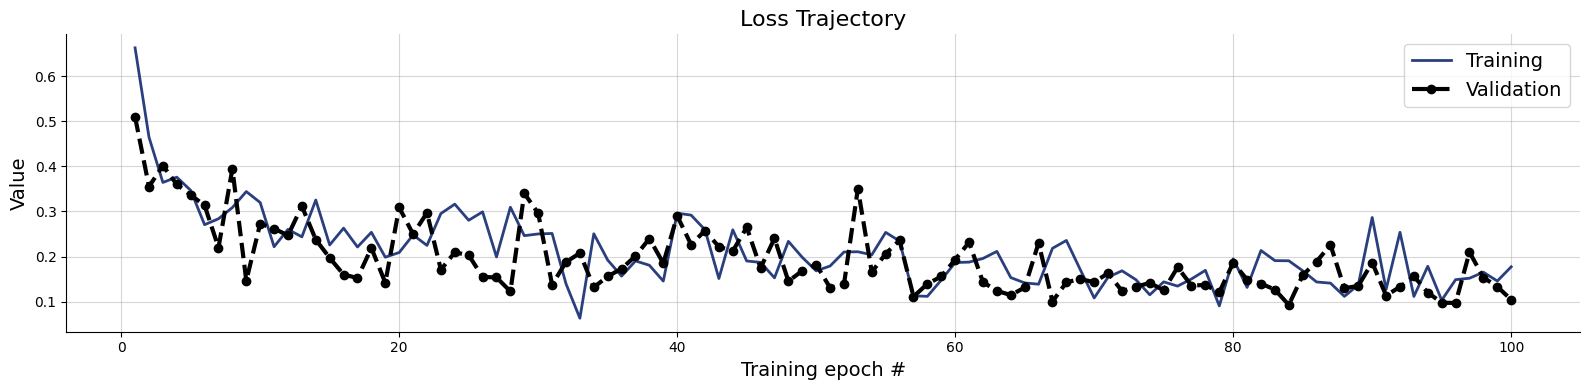

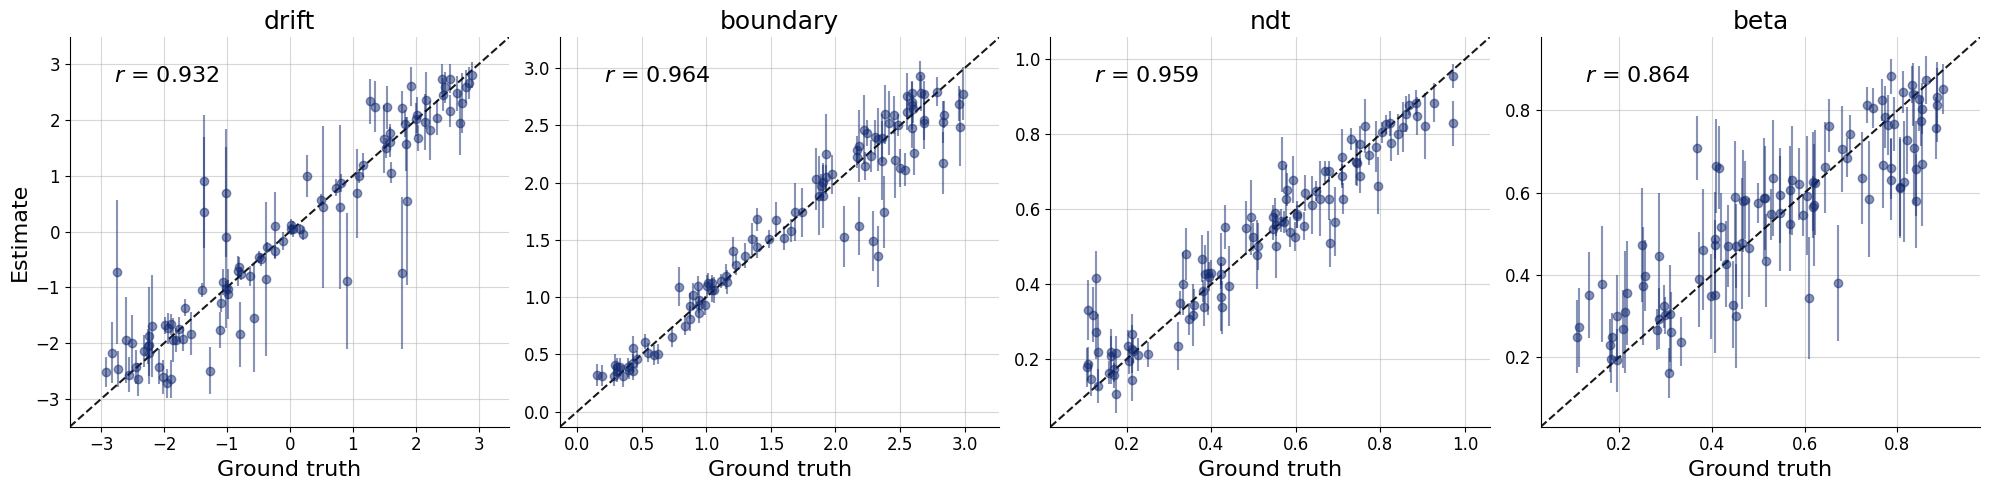

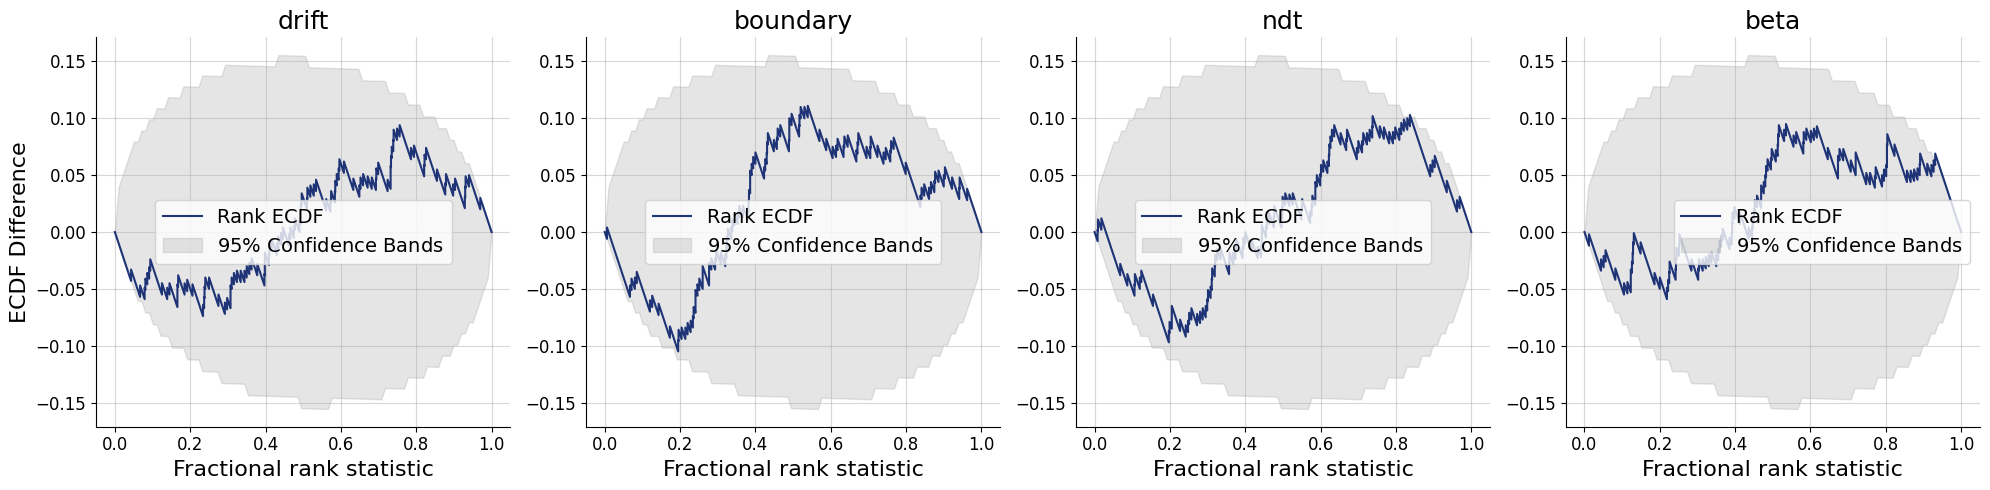

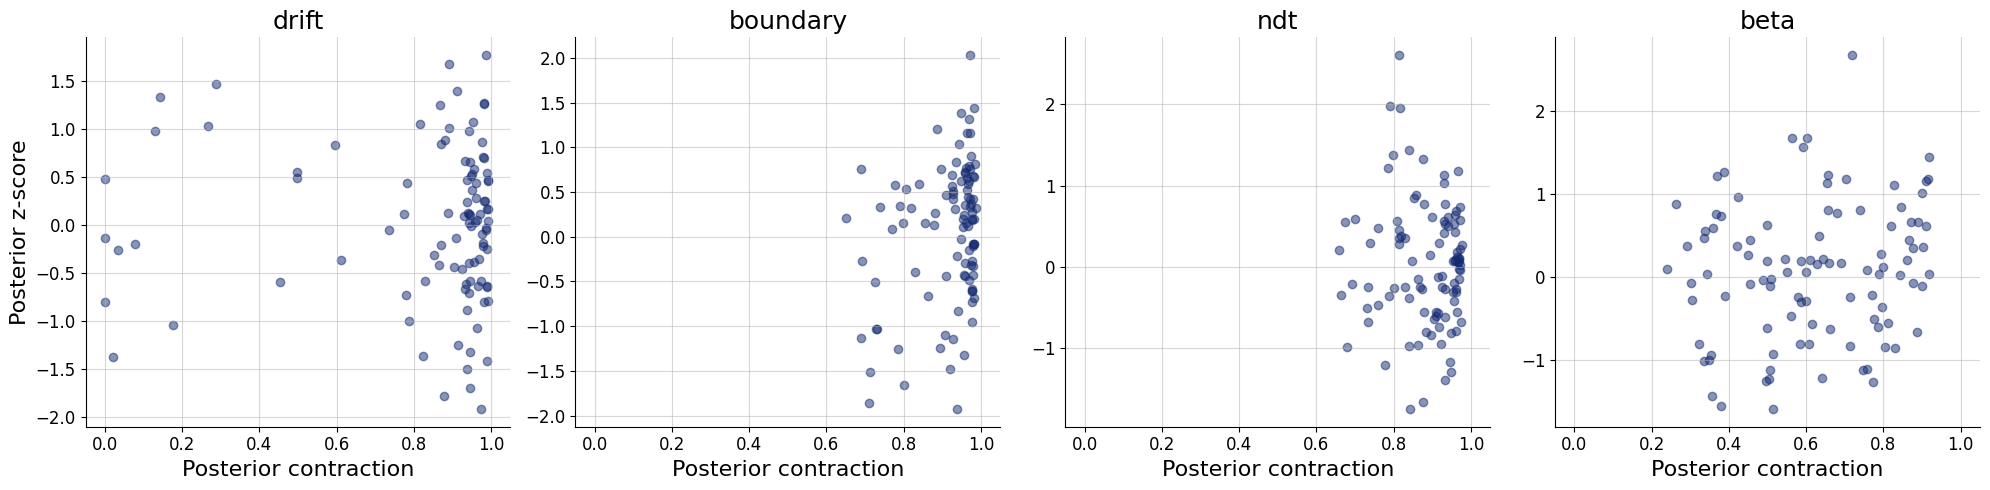

In [10]:
workflow.plot_default_diagnostics(test_data=100, calibration_ecdf_kwargs={"difference": True});

# Score Matching

In [18]:
class Prior:
    def __init__(self):
        self.n_params_global = 4
        self.n_params_local = 0  # not a hierarchical model
        self.param_names = ['drift', 'boundary', 'ndt', 'beta']

        np.random.seed(0)
        sample_dict = simulator.sample(1000)
        thetas_global = np.concatenate([sample_dict['drift'], sample_dict['boundary'],
                                        sample_dict['ndt'], sample_dict['beta']], axis=-1)
        thetas_global = torch.tensor(thetas_global, dtype=torch.float32)

        self.norm_prior_global_mean = torch.mean(thetas_global, dim=0)
        self.norm_prior_global_std = torch.std(thetas_global, dim=0)
        self.current_device = 'cpu'

    def normalize_theta(self, theta, global_params=True):
        self._move_to_device(theta.device)
        if global_params:
            return (theta - self.norm_prior_global_mean) / self.norm_prior_global_std
        raise ValueError('This is not a hierarchical model.')

    def denormalize_theta(self, theta, global_params=True):
        self._move_to_device(theta.device)
        if global_params:
            return theta * self.norm_prior_global_std + self.norm_prior_global_mean
        raise ValueError('This is not a hierarchical model.')

    def normalize_data(self, x):
        self._move_to_device(x.device)
        return x

    def _move_to_device(self, device):
        if self.current_device != device:
            print(f"Moving prior to device: {device}")
            self.norm_prior_global_mean = self.norm_prior_global_mean.to(device)
            self.norm_prior_global_std = self.norm_prior_global_std.to(device)
            self.current_device = device
        return

from diffusion_model.helper_functions import generate_diffusion_time
class DiffusionProblem(Dataset):
    def __init__(self, n_data, prior, sde, online_learning=False, rectified_flow=False):
        # Create model and dataset
        self.prior = prior
        self.sde = sde
        self.n_data = n_data
        self.online_learning = online_learning
        self.rectified_flow = rectified_flow
        self._generate_data()
        self._generate_diffusion_target()

    def _generate_data(self):
        print('generate data')
        # Create model and dataset
        sample_dict = simulator.sample(self.n_data)
        thetas_global = np.concatenate([sample_dict['drift'], sample_dict['boundary'],
                                        sample_dict['ndt'], sample_dict['beta']], axis=-1)
        self.thetas_global_unnormalized = torch.tensor(thetas_global, dtype=torch.float32)
        self.thetas_global = self.prior.normalize_theta(self.thetas_global_unnormalized, global_params=True)
        self.xs = torch.tensor(sample_dict['obs'], dtype=torch.float32)

        #self.xs = self.xs.to(torch_device)
        #self.xs = workflow.summary_network(self.xs)

        # generate new noise only with new data
        if self.rectified_flow:
            self.noise = torch.randn_like(self.thetas_global)

    def _generate_diffusion_target(self):
        # Generate diffusion time and training target
        self.diffusion_time = generate_diffusion_time(size=self.n_data, return_batch=True)

        # perturb the theta batch
        snr = self.sde.get_snr(t=self.diffusion_time)
        self.alpha, self.sigma = self.sde.kernel(log_snr=snr)

        # generate new noise in each epoch
        if not self.rectified_flow:
            self.noise = torch.randn_like(self.thetas_global)

    def __len__(self):
        # this should return the size of the dataset
        return len(self.thetas_global)

    def __getitem__(self, idx):
        # this should return one sample from the dataset
        params = self.thetas_global[idx]
        noise = self.noise[idx]

        param_noisy = self.alpha[idx] * params + self.sigma[idx] * noise

        target = noise  # for e-prediction
        #target = self.alpha[idx] * noise - self.sigma[idx] * params  # for v-prediction

        return param_noisy, params, target, self.xs[idx], self.diffusion_time[idx]

    def on_epoch_end(self):  # for online learning
        # Regenerate data at the end of each epoch
        if self.online_learning:
            self._generate_data()
        self._generate_diffusion_target()

    def on_batch_end(self):
        pass

In [19]:
batch_size = 64
prior = Prior()
current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching'][1],
    #log_snr_min=-10.,
    #s_shift_cosine=-2
)

Kernel type: variance_preserving, noise schedule: cosine
t_min: 0.00035210439818911254, t_max: 0.999647855758667
alpha, sigma: (tensor(1.0000), tensor(0.0006)) (tensor(0.0006), tensor(1.0000))


In [20]:
dataset = DiffusionProblem(
    n_data=10000,
    prior=prior,
    sde=current_sde,
    online_learning=False
)
dataset_valid = DiffusionProblem(
    n_data=1000,
    prior=prior,
    sde=current_sde,
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

generate data
Moving prior to device: cpu
generate data


In [21]:
for test in dataloader:
    params_noisy, params, target, data, time = test
    print(params_noisy.shape, params.shape, target.shape, data.shape, time.shape)
    print(params_noisy[0], params[0])
    #print(time)
    #print(summary_net(data).shape)
    break

torch.Size([64, 4]) torch.Size([64, 4]) torch.Size([64, 4]) torch.Size([64, 100, 2]) torch.Size([64, 1])
tensor([-0.7876,  0.2436, -0.2102,  0.8246]) tensor([-0.0825,  0.7211, -0.5965, -0.0195])


In [24]:
import torch.nn as nn
class SimpleSummary(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 8)
        self.activation = nn.Mish()
        self.pool = nn.AvgPool1d(kernel_size=100)

    def forward(self, x):
        out = self.linear(x)
        out = self.activation(out)
        out = out.permute(0, 2, 1)  # make obs last dimension
        out = self.pool(out).squeeze(-1)
        return out

In [39]:
# Define diffusion model
score_model = ScoreModel(
    input_dim_theta=prior.n_params_global,
    input_dim_x=8,
    #time_embedding=time_embedding,
    #summary_net=SetTransformer(dim_input=2, num_outputs=1, dim_output=8),
    #summary_net=SimpleSummary(),
    summary_net=ShallowSet(dim_input=2, dim_output=8),
    hidden_dim=256,
    n_blocks=5,
    use_film=False,
    prediction_type=['score', 'e', 'x', 'v'][1],
    loss_type=['e', 'v'][0],
    sde=current_sde,
    prior=prior,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid'][0],
    name_prefix='diffusion_',
    full_res_layer=False,
    max_number_of_obs=100
)
count_parameters(score_model)
print(score_model.name)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

+--------------------------------------+------------+
|               Modules                | Parameters |
+--------------------------------------+------------+
|       summary_net.enc.0.weight       |    256     |
|        summary_net.enc.0.bias        |    128     |
|       summary_net.enc.2.weight       |   16384    |
|        summary_net.enc.2.bias        |    128     |
|       summary_net.enc.4.weight       |   16384    |
|        summary_net.enc.4.bias        |    128     |
|       summary_net.enc.6.weight       |   16384    |
|        summary_net.enc.6.bias        |    128     |
|       summary_net.dec.0.weight       |   16384    |
|        summary_net.dec.0.bias        |    128     |
|       summary_net.dec.2.weight       |   16384    |
|        summary_net.dec.2.bias        |    128     |
|       summary_net.dec.4.weight       |   16384    |
|        summary_net.dec.4.bias        |    128     |
|       summary_net.dec.6.weight       |    1024    |
|        summary_net.dec.6.b

Training e-model for 100 epochs with learning rate 0.0005 and None weighting.


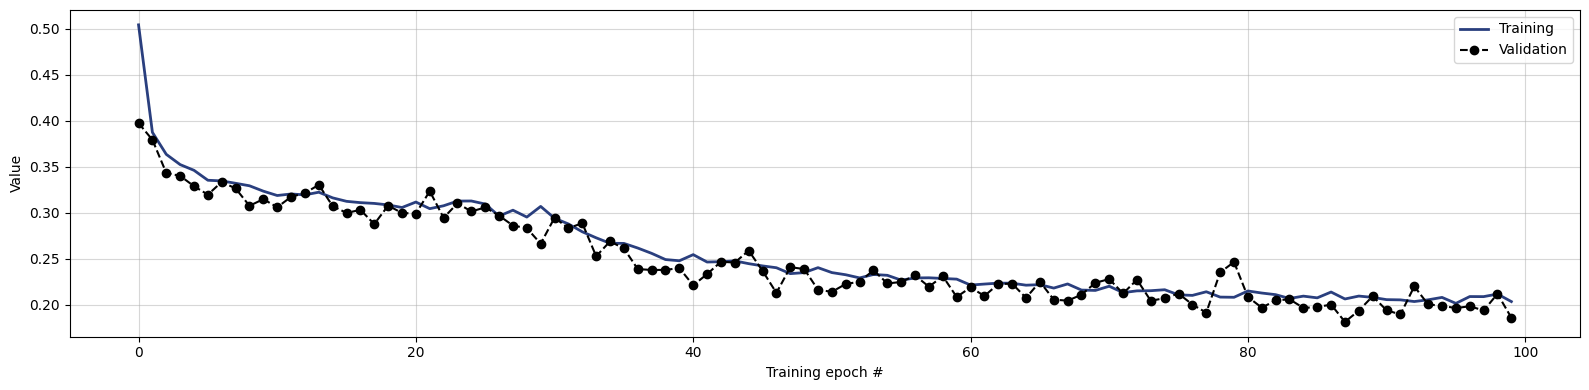

In [40]:
# train model
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid,
                                 epochs=100, device=torch_device)
score_model.eval()
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

# plot loss history
plt.figure(figsize=(16, 4), tight_layout=True)
plt.plot(loss_history[:, 0], label='Training', color="#132a70", lw=2.0, alpha=0.9)
plt.plot(loss_history[:, 1], label='Validation', linestyle="--", marker="o", color='black')
plt.grid(alpha=0.5)
plt.xlabel('Training epoch #')
plt.ylabel('Value')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')

## Sampling

In [41]:
from diffusion_model import langevin_sampling, adaptive_sampling, euler_maruyama_sampling

In [42]:
n_post_samples = 100

dataset_test = DiffusionProblem(
    n_data=100,
    prior=prior,
    sde=current_sde,
)

valid_data = dataset_test.xs
valid_prior = dataset_test.thetas_global_unnormalized
param_names = prior.param_names

#valid_data = valid_data.reshape(100, 1, 8)
#score_model.current_number_of_obs = 100

generate data
Moving prior to device: cpu


In [48]:
posterior_global_samples_valid = euler_maruyama_sampling(score_model, valid_data, n_post_samples=n_post_samples,
                                                        #mini_batch_arg=mini_batch_arg,
                                                        diffusion_steps=1000,
                                                        device=torch_device, verbose=True)

# posterior_global_samples_valid = langevin_sampling(score_model, valid_data, n_post_samples=n_post_samples,
#                                                     #mini_batch_arg=mini_batch_arg,
#                                                     diffusion_steps=100, langevin_steps=5, step_size_factor=0.05,
#                                                     device=torch_device, verbose=True)

# posterior_global_samples_valid = adaptive_sampling(score_model, valid_data, n_post_samples=n_post_samples,
#                                                   #mini_batch_arg=mini_batch_arg,
#                                                   run_sampling_in_parallel=False,
#                                                   device=torch_device, verbose=True)

100%|██████████| 1000/1000 [00:13<00:00, 74.74it/s]


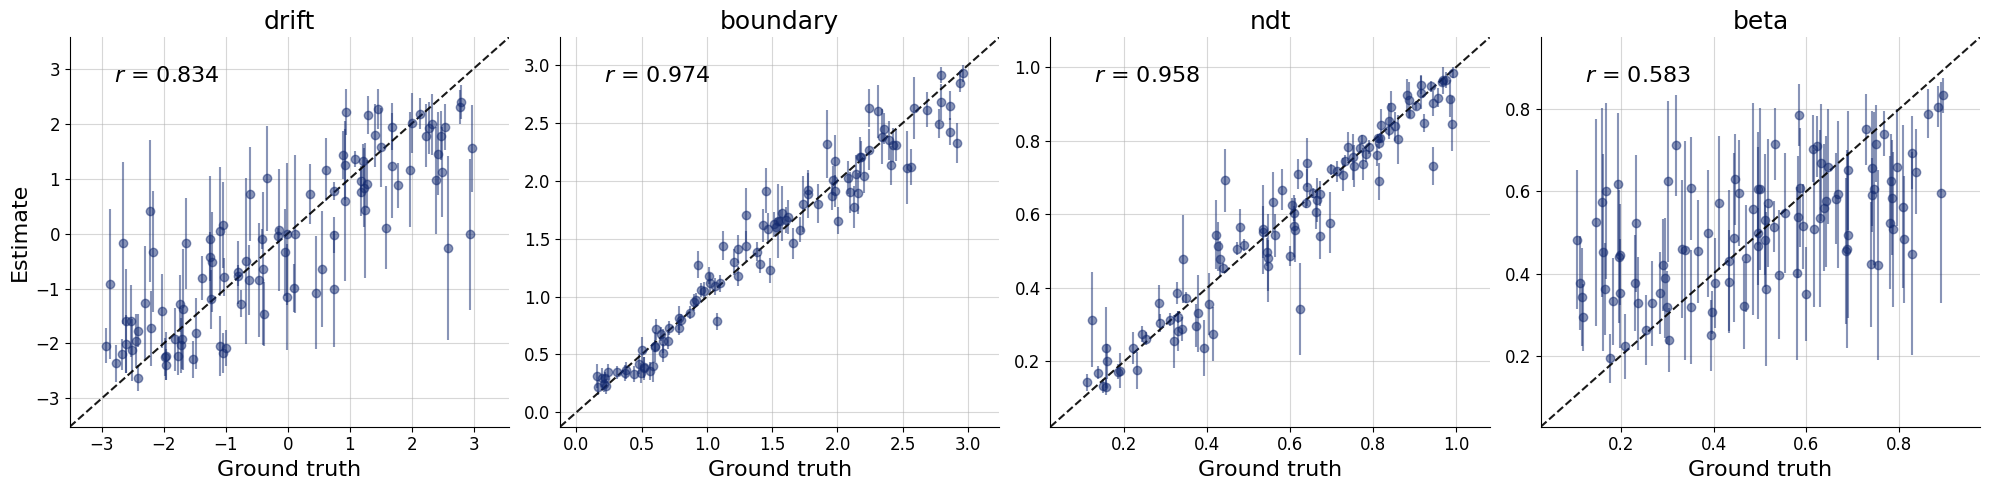

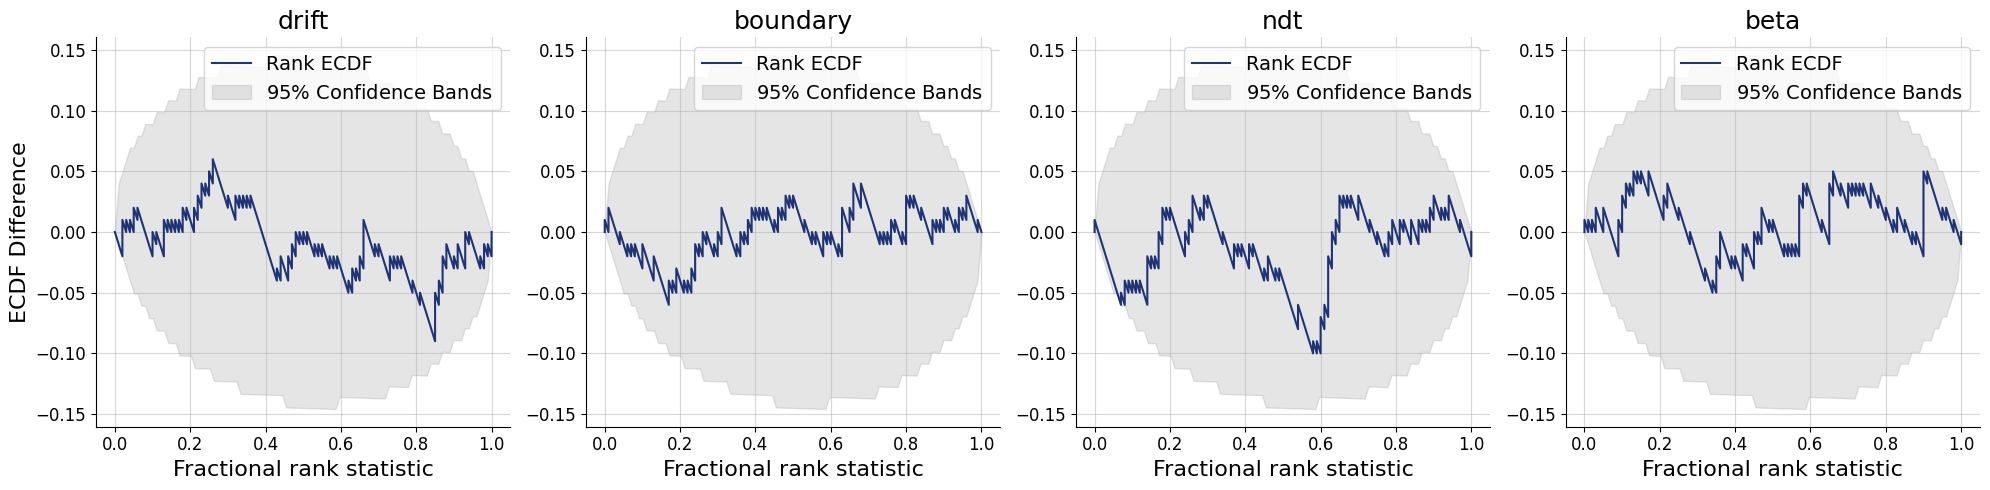

In [49]:
diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior), variable_names=param_names)
diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior),
                             difference=True, variable_names=param_names);